# Setup

In [1]:
import importlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from numpy.linalg import cond
from typing import List

# Matrixlib
from matrixlib import preconditioning as precon
from matrixlib.core import MatrixData, ValueProperties, BlockProperties

# Generate Synthetic Data
Generate a set of `n` square symmetrical and positive semi matrices of dimensions `MATRIX_DIM` to RAM.

## Define Constants
The following constants are used throughout the rest of the notebook.

In [2]:
MATRIX_DIM = 64
NUMBER_OF_MATRICES = 100
DIAGONAL_BAND_RADIUS = 10
RNG_SEED = 42

VALUE_COLORBAR = 'rocket'
BLOCK_COLORBAR = 'flare'

In [3]:
# Generate matrices
bgr_noise_value_props = ValueProperties(density_range=(0.3, 0.5), value_range=(0.0, 0.5))
noise_blk_value_props = ValueProperties(density_range=(0.3, 0.5), value_range=(0.3, 1.0))
noise_blk_block_props = BlockProperties(size_range=(3, 32), size_average=10, size_std_dev=0.66, gap_chance=0.5)
tdata_blk_value_props = ValueProperties(density_range=(0.5, 0.7), value_range=(0.3, 1.0))
tdata_blk_block_props = BlockProperties(size_range=(2, 32), size_average=10, size_std_dev=0.66, gap_chance=0.0)

test_data = MatrixData(
        dimension=MATRIX_DIM,
        band_radius=DIAGONAL_BAND_RADIUS,
        sample_size=NUMBER_OF_MATRICES,
        background_noise_value_properties=bgr_noise_value_props,
        block_noise_value_properties=noise_blk_value_props,
        block_noise_block_properties=noise_blk_block_props,
        block_data_value_properties=tdata_blk_value_props,
        block_data_block_properties=tdata_blk_block_props,
        seed=42,
        determinant_cutoff=0.01,
        print_debug=False
    )

In [4]:
labels = test_data.tdata_blk_starts
A_orig = test_data.matrices

# Verify Shape
print(f"Test Matrices Shape: {A_orig.shape}, Test Labels Shape: {labels.shape}")

Test Matrices Shape: (100, 64, 64), Test Labels Shape: (100, 64)


# Create Preconditioner from predicted block starts
### 1. Generate variants of the original matrix data as inversion targets (i.e. 'A' in 'Ax = b')

In [5]:
importlib.reload(precon)

A_flip = np.array([precon.prepare_matrix(A_orig[i], method='flip') for i in range(NUMBER_OF_MATRICES)])
A_shift = np.array([precon.prepare_matrix(A_orig[i], method='shift') for i in range(NUMBER_OF_MATRICES)])
A_minmax = np.array([precon.prepare_matrix(A_orig[i], method='minmax') for i in range(NUMBER_OF_MATRICES)])

### 2. Invert Blocks (ensure non-singularity)

In [6]:
precs = precon.block_jacobi_preconditioner_from_predictions(A_orig, labels)

Matrix is singular, using pseudo-inverse for block 4 at indices 62:64
Matrix is singular, using pseudo-inverse for block 35 at indices 62:64
Matrix is singular, using pseudo-inverse for block 65 at indices 61:64
Matrix is singular, using pseudo-inverse for block 66 at indices 60:64
Matrix is singular, using pseudo-inverse for block 74 at indices 62:64
Matrix is singular, using pseudo-inverse for block 75 at indices 60:64
Matrix is singular, using pseudo-inverse for block 80 at indices 3:5
Matrix is singular, using pseudo-inverse for block 88 at indices 60:64


### 3. Analyze resulting data

In [7]:
# Check Condition Numbers
TARGET_INDEX = 0

# Select indices to analyze here 
ANALYTICS_TARGETS = [0, 1, 2, 3]

In [8]:

print(f"Analysing matrix at index [{TARGET_INDEX}]:")
print("-" * 80)
print("Condition number:")
print("-" * 80)
print(f"original: {cond(A_orig[TARGET_INDEX]):12.2f}")
print(f"precon:   {cond(precs[TARGET_INDEX]):12.2f}")
print(f"flipped:  {cond(A_flip[TARGET_INDEX]):12.2f}")
print(f"shifted:  {cond(A_shift[TARGET_INDEX]):12.2f}")
print(f"minmax:   {cond(A_minmax[TARGET_INDEX]):12.2f}")
print("-" * 80)
print("Condition number Product:")
print("-" * 80)
print(f"flipped:  {cond(np.matmul(A_flip[TARGET_INDEX], precs[TARGET_INDEX])):12.2f}")
print(f"shifted:  {cond(np.matmul(A_shift[TARGET_INDEX], precs[TARGET_INDEX])):12.2f}")
print("-" * 80)
print("Frobenius norm of difference between preconditioner and inverse:")
print("-" * 80)
print(f"flipped:  {np.linalg.norm(precs[TARGET_INDEX] - np.linalg.inv(A_flip[TARGET_INDEX])):12.2f}")
print(f"shifted:  {np.linalg.norm(precs[TARGET_INDEX] - np.linalg.inv(A_shift[TARGET_INDEX])):12.2f}")

Analysing matrix at index [0]:
--------------------------------------------------------------------------------
Condition number:
--------------------------------------------------------------------------------
original:      3626.69
precon:          30.13
flipped:        282.36
shifted:     128859.25
minmax:         514.14
--------------------------------------------------------------------------------
Condition number Product:
--------------------------------------------------------------------------------
flipped:       5691.66
shifted:    2772905.25
--------------------------------------------------------------------------------
Frobenius norm of difference between preconditioner and inverse:
--------------------------------------------------------------------------------
flipped:         46.92
shifted:       2489.10


In [9]:
print(f"Shape of matrix data:           {A_orig.shape}")
print(f"Shape of preconditioner data:   {precs.shape}")

for i in range(min(len(ANALYTICS_TARGETS), NUMBER_OF_MATRICES)):
    print("-" * 80)
    print(f"Condition number of matrix {ANALYTICS_TARGETS[i]:4d} (original): {np.linalg.cond(A_orig[ANALYTICS_TARGETS[i]]):12.2f}")
    print(f"Condition number of matrix {ANALYTICS_TARGETS[i]:4d} (flipped):  {np.linalg.cond(A_flip[ANALYTICS_TARGETS[i]]):12.2f}")
    print(f"Condition number of matrix {ANALYTICS_TARGETS[i]:4d} (shifted):  {np.linalg.cond(A_shift[ANALYTICS_TARGETS[i]]):12.2f}")
    print(f"Condition number of matrix {ANALYTICS_TARGETS[i]:4d} (minmax):   {np.linalg.cond(A_minmax[ANALYTICS_TARGETS[i]]):12.2f}")


Shape of matrix data:           (100, 64, 64)
Shape of preconditioner data:   (100, 64, 64)
--------------------------------------------------------------------------------
Condition number of matrix    0 (original):      3626.69
Condition number of matrix    0 (flipped):        282.36
Condition number of matrix    0 (shifted):     128859.25
Condition number of matrix    0 (minmax):         514.14
--------------------------------------------------------------------------------
Condition number of matrix    1 (original):       314.81
Condition number of matrix    1 (flipped):        323.26
Condition number of matrix    1 (shifted):       9097.94
Condition number of matrix    1 (minmax):         903.13
--------------------------------------------------------------------------------
Condition number of matrix    2 (original):       188.17
Condition number of matrix    2 (flipped):        482.56
Condition number of matrix    2 (shifted):       1732.62
Condition number of matrix    2 (minma

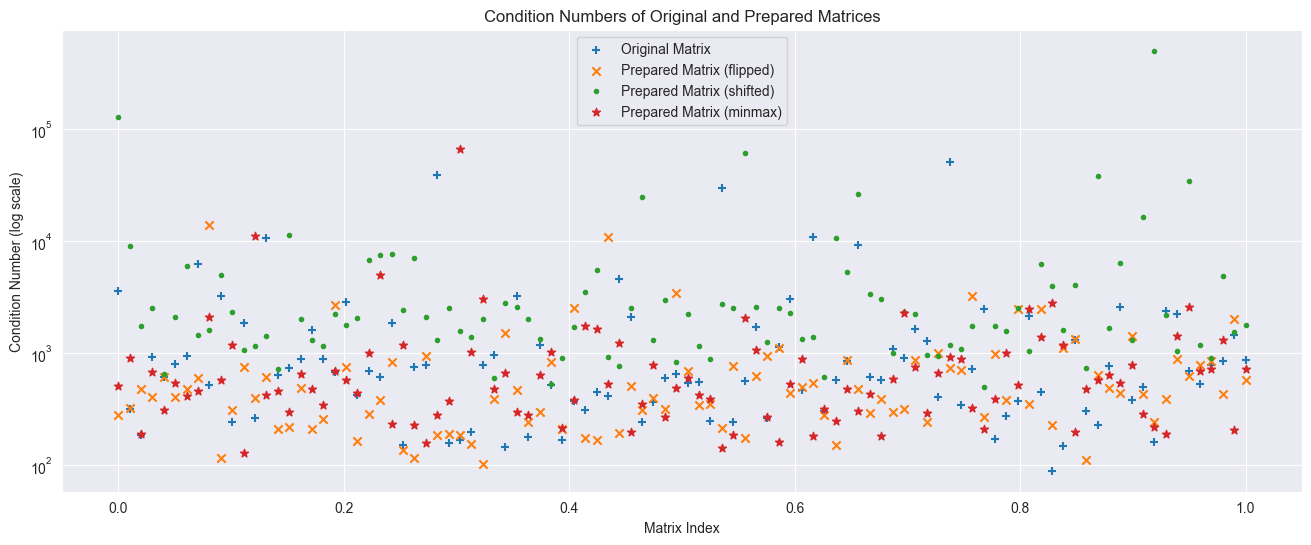

In [10]:
# generate x axis vector
x_vals = np.linspace(0, 1, num=NUMBER_OF_MATRICES)

# plot condition numbers 
plt.figure(figsize=(16, 6))
plt.scatter(x_vals, [np.linalg.cond(A_orig[i]) for i in range(A_orig.shape[0])], label='Original Matrix', marker='+')
plt.scatter(x_vals, [np.linalg.cond(A_flip[i]) for i in range(A_flip.shape[0])], label='Prepared Matrix (flipped)', marker='x')
plt.scatter(x_vals, [np.linalg.cond(A_shift[i]) for i in range(A_shift.shape[0])], label='Prepared Matrix (shifted)', marker='.')
plt.scatter(x_vals, [np.linalg.cond(A_minmax[i]) for i in range(A_minmax.shape[0])], label='Prepared Matrix (minmax)', marker='*')
plt.xlabel('Matrix Index')
plt.ylabel('Condition Number (log scale)')
plt.gca().set_yscale('log')
plt.title('Condition Numbers of Original and Prepared Matrices')
plt.legend()
plt.show()

# Run GMRES Solver with and without Preconditioner

In [15]:
importlib.reload(precon)

# Generate solution value vector
b = np.ones((NUMBER_OF_MATRICES, MATRIX_DIM))

# Solve with and without preconditioner
print("Running GMRES without preconditioner")
print("=" * 80)
print("Running GMRES for raw test matrices without preconditioner")
x_no_precon_orig, info_no_precon_orig, iters_no_precon_orig, residuals_no_precon_orig = precon.solve_with_gmres_monitored(A=A_orig, b=b)
print("Running GMRES for prepared matrices (flipped) without preconditioner")
x_no_precon_flip, info_no_precon_flip, iters_no_precon_flip, residuals_no_precon_flip = precon.solve_with_gmres_monitored(A=A_flip, b=b)
print("Running GMRES for prepared matrices (shifted) without preconditioner")
x_no_precon_shift, info_no_precon_shift, iters_no_precon_shift, residuals_no_precon_shift = precon.solve_with_gmres_monitored(A=A_shift, b=b)
print("Running GMRES for prepared matrices (minmax) without preconditioner")
x_no_precon_minmax, info_no_precon_minmax, iters_no_precon_minmax, residuals_no_precon_minmax = precon.solve_with_gmres_monitored(A=A_minmax, b=b)
print("=" * 80)

print("Running GMRES with preconditioner")
print("=" * 80)
print("Running GMRES for raw test matrices with preconditioner base on test matrices")
x_precon_orig, info_precon_orig, iters_precon_orig, residuals_precon_orig = precon.solve_with_gmres_monitored(A=A_orig, b=b, M=precs)
print("Running GMRES for prepared matrices (flipped) with preconditioner base on test matrices")
x_precon_flip, info_precon_flip, iters_precon_flip, residuals_precon_flip = precon.solve_with_gmres_monitored(A=A_flip, b=b, M=precs)
print("Running GMRES for prepared matrices (shifted) with preconditioner base on test matrices")
x_precon_shift, info_precon_shift, iters_precon_shift, residuals_precon_shift = precon.solve_with_gmres_monitored(A=A_shift, b=b)
print("Running GMRES for prepared matrices (minmax) with preconditioner base on test matrices")
x_precon_minmax, info_precon_minmax, iters_precon_minmax, residuals_precon_minmax = precon.solve_with_gmres_monitored(A=A_minmax, b=b, M=precs)

Running GMRES without preconditioner
Running GMRES for raw test matrices without preconditioner
**********
--------------------------------------------------------------------------------
Without preconditioner:
  Converged: 88 out of 100
  Average iterations: 3980.00
  iterations: [12800   589   617  3321  3025  6544  8593 12623  2201  7750   756  3160
   719 12800  2577   443  2090  5916  3944  3777 12800  1708   992  2036
  2890   611  1662  2150 12800   526   468   729  5587  8500   347 12800
   601  7476  4312   642  1365   825  2941  2356 12800   300   746  1611
  1502  2655  2676   509  1712 12800   757  2484  7535  1696  6171 12800
  2122 12800  1403   744  6040 12800  3415  4792  6695   306   513  2482
  1755 12800  1978  2878  8006   798   762  2275  3843   510   152   379
 12800  1542   849  3977  5046   933  3790   582 10291  6427  1843   508
  1978  2055  4551   457]
--------------------------------------------------------------------------------
Running GMRES for prepared

In [16]:
# precalculate some norms
norm_b = [np.linalg.norm(b[i]) for i in range(NUMBER_OF_MATRICES)]

# Calculate and print the relative residuals
rel_residuals_flip_no_precon = [np.linalg.norm(b[i] - A_flip[i] @ x_no_precon_flip[i]) / norm_b[i] for i in range(NUMBER_OF_MATRICES)]
rel_residuals_flip_precon = [np.linalg.norm(b[i] - A_flip[i] @ x_precon_flip[i]) / norm_b[i] for i in range(NUMBER_OF_MATRICES)]

print("")
print("Relative residual for 'flipped' matrices:")
print(f"  Without preconditioner: "
      f"min={np.min(rel_residuals_flip_no_precon):.2e}, "
      f"max={np.max(rel_residuals_flip_no_precon):.2e}, "
      f"mean={np.mean(rel_residuals_flip_no_precon):.2e}")
print(f"  With preconditioner: "
      f"min={np.min(rel_residuals_flip_precon):.2e}, "
      f"max={np.max(rel_residuals_flip_precon):.2e}, "
      f"mean={np.mean(rel_residuals_flip_precon):.2e}")


Relative residual for 'flipped' matrices:
  Without preconditioner: min=2.14e-04, max=9.30e-03, mean=1.16e-03
  With preconditioner: min=2.98e-04, max=9.01e-02, mean=4.76e-03


Iteration count statistics without preconditioner:
--------------------------------------------------------------------------------
Original: {'min': 152, 'max': 12800, 'mean': 3980.0, 'median': 2238.0}
Flipped:  {'min': 101, 'max': 12800, 'mean': 2550.53, 'median': 1206.0}
Shifted:  {'min': 39, 'max': 12800, 'mean': 1165.92, 'median': 358.5}
Minmax:   {'min': 148, 'max': 12800, 'mean': 2254.21, 'median': 1338.5}
--------------------------------------------------------------------------------
Iteration count statistics with preconditioner:
--------------------------------------------------------------------------------
Original: {'min': 199, 'max': 12800, 'mean': 3824.4, 'median': 1463.0}
Flipped:  {'min': 114, 'max': 12800, 'mean': 2492.48, 'median': 956.5}
Shifted:  {'min': 39, 'max': 12800, 'mean': 1165.92, 'median': 358.5}
Minmax:   {'min': 214, 'max': 12800, 'mean': 2185.12, 'median': 1165.5}
--------------------------------------------------------------------------------


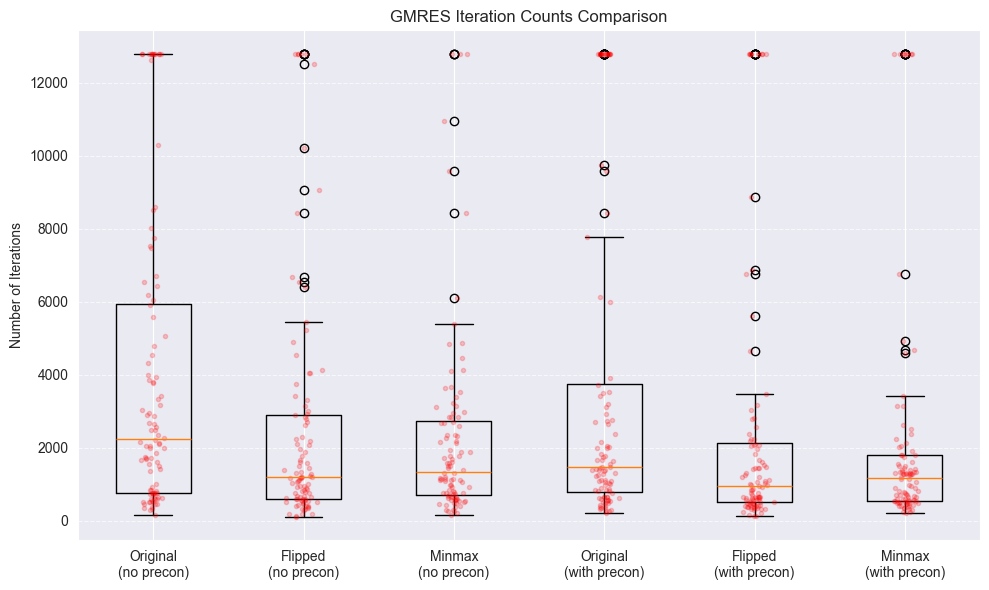

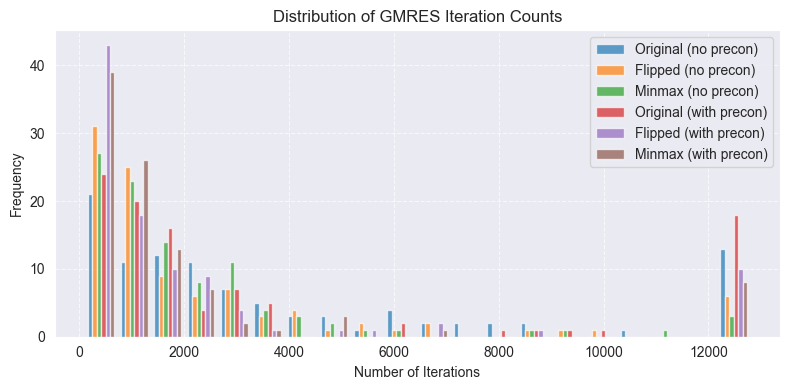

In [17]:
# Calculate statistics for iteration counts
def iter_stats(iters):
    return {
        'min': np.min(iters),
        'max': np.max(iters),
        'mean': np.mean(iters),
        'median': np.median(iters)
    }

# Print statistics
print("Iteration count statistics without preconditioner:")
print("-" * 80)
print(f"Original: {iter_stats(iters_no_precon_orig)}")
print(f"Flipped:  {iter_stats(iters_no_precon_flip)}")
print(f"Shifted:  {iter_stats(iters_no_precon_shift)}")
print(f"Minmax:   {iter_stats(iters_no_precon_minmax)}")
print("-" * 80)
print("Iteration count statistics with preconditioner:")
print("-" * 80)
print(f"Original: {iter_stats(iters_precon_orig)}")
print(f"Flipped:  {iter_stats(iters_precon_flip)}")
print(f"Shifted:  {iter_stats(iters_precon_shift)}")
print(f"Minmax:   {iter_stats(iters_precon_minmax)}")
print("-" * 80)

# Define some arrays
result_data_list = [
    iters_no_precon_orig,
    iters_no_precon_flip,
    iters_no_precon_minmax,
    iters_precon_orig,
    iters_precon_flip,
    iters_precon_minmax,
]
result_data_labels_long = [
    'Original (no precon)',
    'Flipped (no precon)',
    'Minmax (no precon)',
    'Original (with precon)',
    'Flipped (with precon)',
    'Minmax (with precon)'
]
result_data_labels_stacked = [
    'Original\n(no precon)',
    'Flipped\n(no precon)',
    'Minmax\n(no precon)',
    'Original\n(with precon)',
    'Flipped\n(with precon)',
    'Minmax\n(with precon)'
]

# Create box plots
plt.figure(figsize=(10, 6))
bp = plt.boxplot(result_data_list, tick_labels=result_data_labels_stacked)

plt.title('GMRES Iteration Counts Comparison')
plt.ylabel('Number of Iterations')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add some jitter to the data points
for i, data in enumerate(result_data_list, 1):
    x = np.random.normal(i, 0.04, size=len(data))
    plt.plot(x, data, 'r.', alpha=0.2)

plt.tight_layout()
plt.show()

# Histogram
plt.figure(figsize=(8, 4))
plt.hist(result_data_list, label=result_data_labels_long, bins=20, alpha=0.7)
plt.xlabel('Number of Iterations')
plt.ylabel('Frequency')
plt.title('Distribution of GMRES Iteration Counts')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

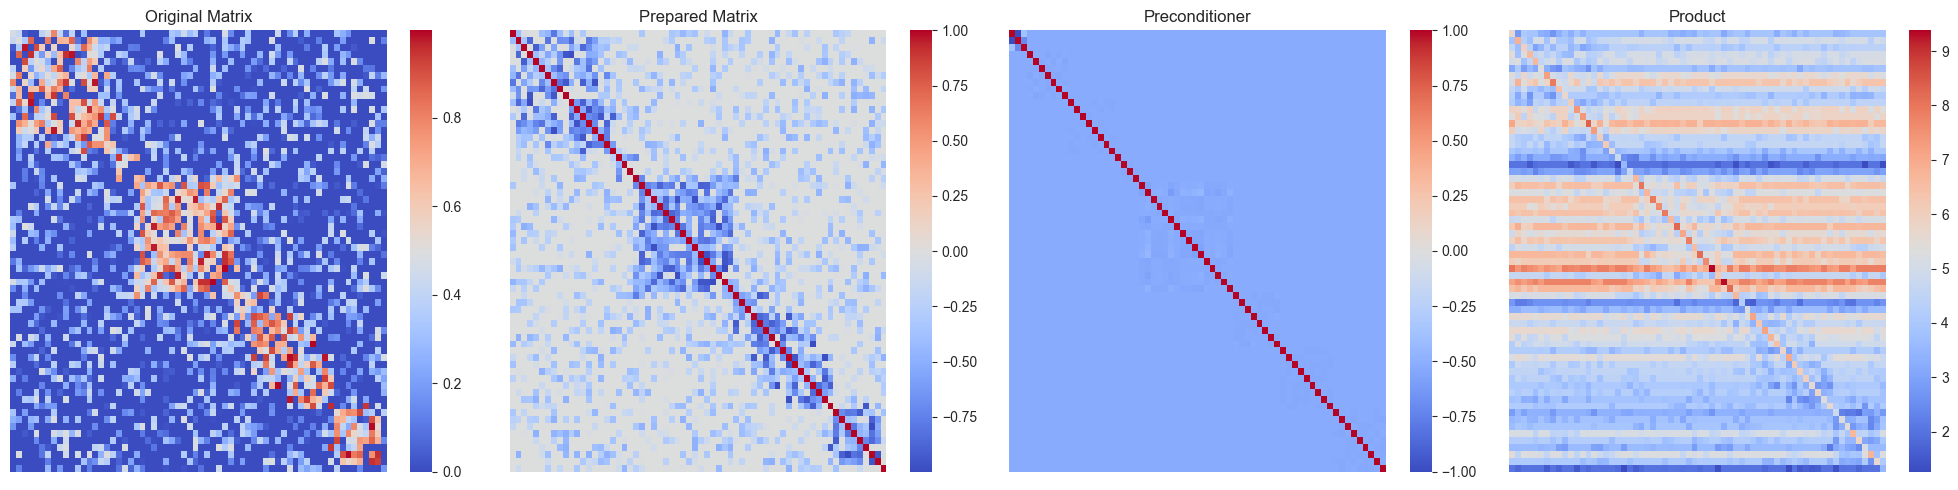

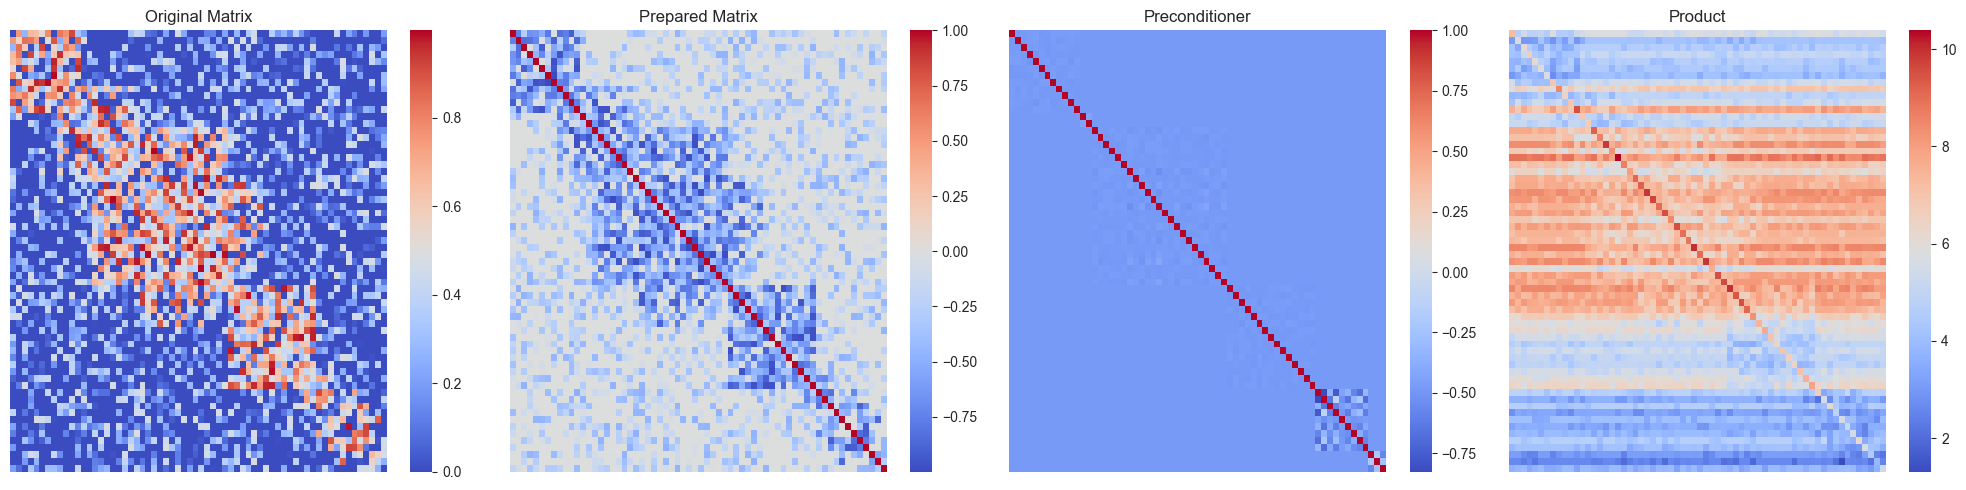

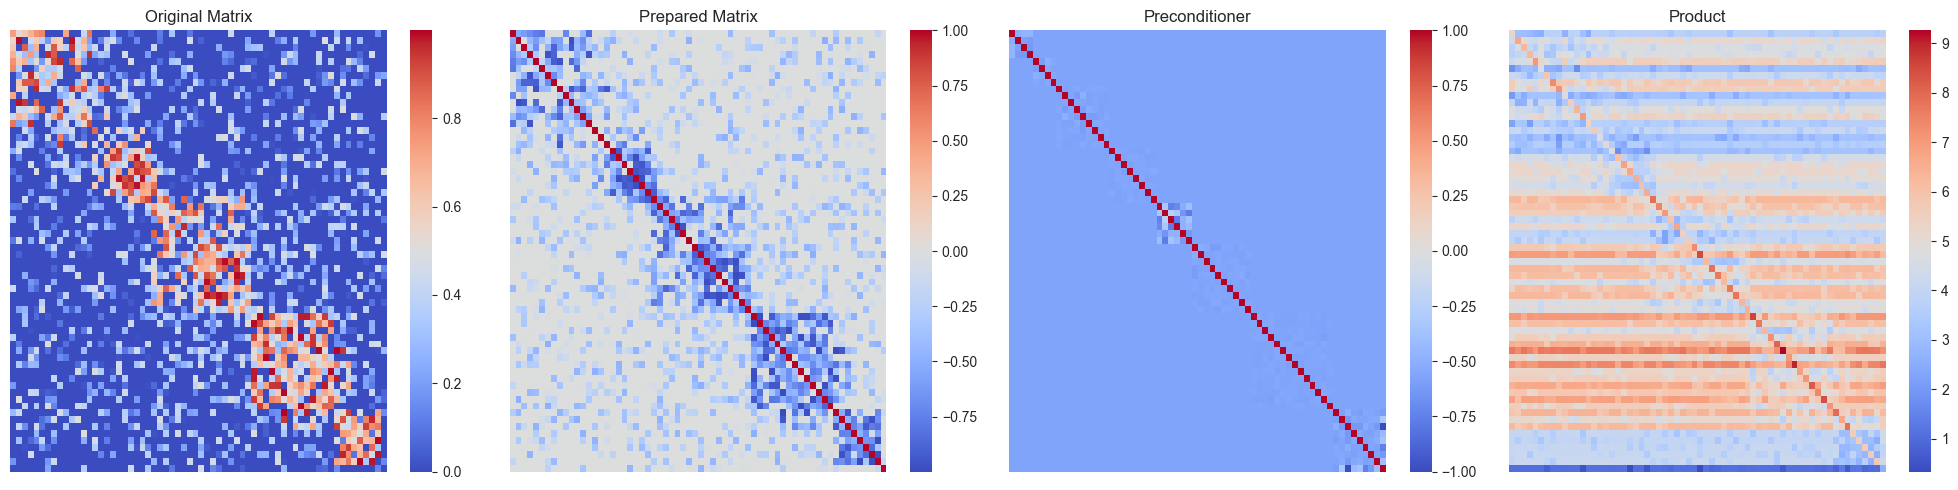

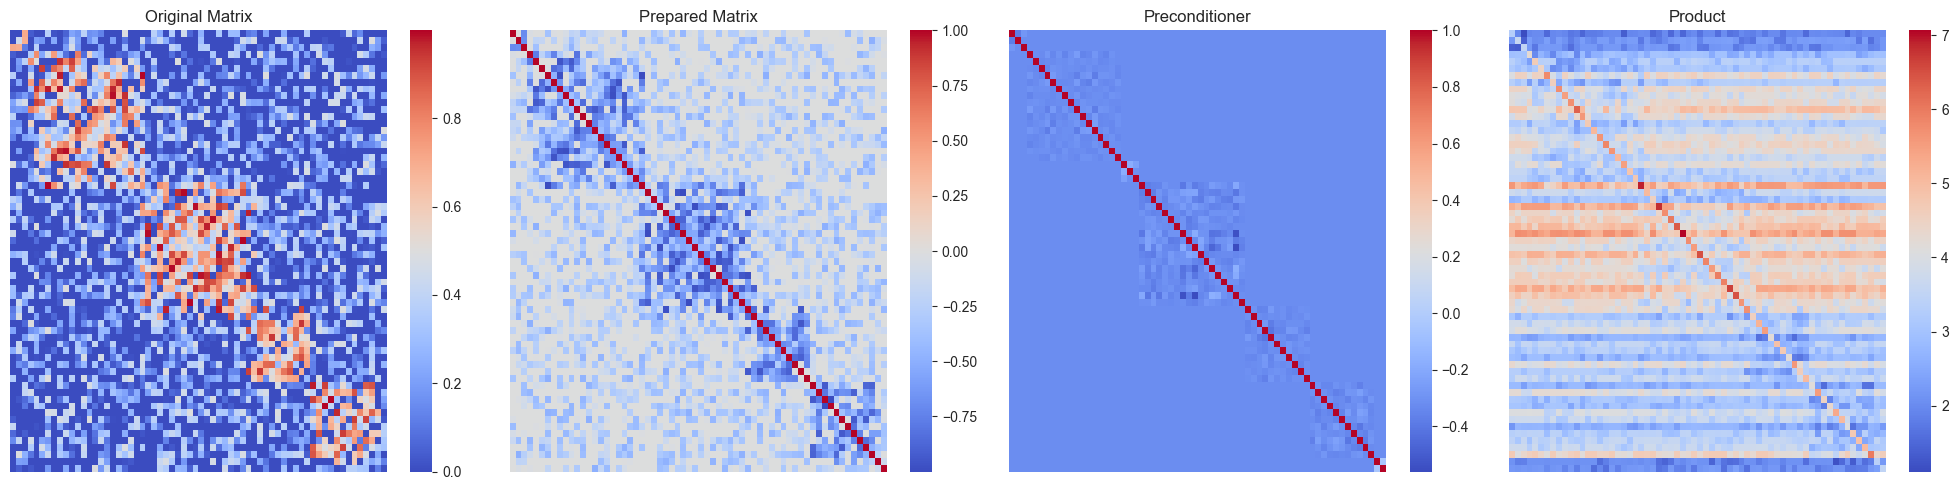

In [18]:
# Function to plot matrices
def plot_matrices(matrices: List[np.ndarray], titles: List[str], colorbar: str = VALUE_COLORBAR) -> None:
    num_matrices = len(matrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=(5 * num_matrices, 5))

    for i, (matrix, title) in enumerate(zip(matrices, titles)):
        ax = axes[i] if num_matrices > 1 else axes
        sns.heatmap(matrix, cmap=colorbar, ax=ax, cbar=True)
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()
    
# Plot matrices
for i in range(len(ANALYTICS_TARGETS)):
    index = ANALYTICS_TARGETS[i]
    plot_matrices(
        [A_orig[index], A_flip[index], precs[index], np.matmul(A_flip[index], precs[index])], 
        ['Original Matrix', 'Prepared Matrix', 'Preconditioner', 'Product'], 
        colorbar='coolwarm'
    )

End of notebook.